In [16]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
import random
from typing import List
import scipy.integrate as integrate

In [59]:
def integrand(z, mu_0:float, mu_1:float, std_0:float, std_1: float, P1t: float):
    l0_value = max(stats.norm.pdf(x=z, loc=mu_0, scale=std_0), 1e-10)
    l1_value = max(stats.norm.pdf(x=z, loc=mu_1, scale=std_1), 1e-10)
    term1 = P1t*l1_value*math.log(l1_value/(l0_value*(1-P1t)+l1_value*P1t))
    term2 = (1-P1t)*l0_value*math.log(l0_value/(l0_value*(1-P1t)+l1_value*P1t))
    return term1 + term2


def adaptive_select_flash(P_all, board, mu_0, mu_1, std_0, std_1):
    n_rows  = board.shape[0]
    n_cols  = board.shape[1]
    num_group = n_rows + n_cols
    groups = [i for i in range(num_group)]
    MIs = [] # mutual information score for every flash group
    for flashed in groups:
        flashed_row = flashed if flashed < 6 else -1 # -1 if a col is flahsed
        flashed_col = flashed - 6 if flashed_row == -1 else -1
        if (flashed != -1):
            P1t = sum(P_all[flashed_row,:])
        else:
            P1t = sum(P_all[:,flashed_col])
        MI = integrate.quad(lambda z: integrand(z,mu_0,mu_1,std_0,std_1,P1t),
                            a=-np.inf, b=+np.inf)[0]
        MIs.append(MI)
    if (len(set(MIs)) == 1):
        selection = random.randint(0, num_group)
    else:
        selection = groups[MIs.index(max(MIs))]
    print(selection)
    return selection

In [60]:
# Initialization
board = np.array([['A', 'G', 'M', 'S', 'Y',   '*'   ],
                  ['B', 'H', 'N', 'T', 'Z',   '*'   ],
                  ['C', 'I', 'O', 'U', '*',   'TALK'],
                  ['D', 'J', 'P', 'V', 'FLN', 'SPAC'],
                  ['E', 'K', 'G', 'W', '*',   'BKSP'],
                  ['F', 'L', 'R', 'X', 'SPL', 'QUIT']])
n_rows = board.shape[0]
n_cols = board.shape[1]
num_seq= n_rows + n_cols
seq = [i for i in range(num_seq)]
s = 10 # sequence_limit
t_max = s * num_seq # the maximum time for data collection (number of trials)
N = 100 # number of iterations (one epoch per iteration)
M = n_rows * n_cols # the amount of possible choices
target_loc = (1,0)
P_all = np.ones(shape=(n_rows, n_cols)) * (1/M)
P_threshold = 0.9

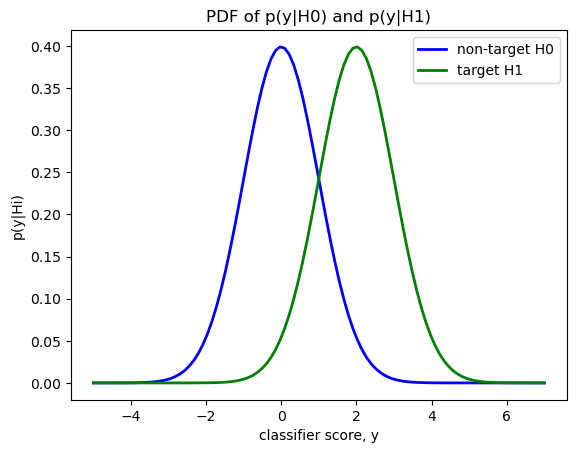

In [61]:
# Visualize the PDF curve for p(y|H0) and p(y|H1) respectively
mu_0 = 0  # mean for p(y|H0) distribution
var_0 = 1 # variance for p(y|H1) distribution
std_0 = math.sqrt(var_0) # std for p(y|H0) distribution
mu_1 = 2
var_1 = 1
std_1 = math.sqrt(var_1)
x = np.linspace(-5, 7, 100)
plt.plot(x, stats.norm.pdf(x, mu_0, std_0), lw=2, c='blue')
plt.plot(x, stats.norm.pdf(x, mu_1, std_1), lw=2, c='green')
plt.title('PDF of p(y|H0) and p(y|H1)')
plt.xlabel('classifier score, y')
plt.ylabel('p(y|Hi)')
plt.legend(labels=['non-target H0', 'target H1'])
plt.show()

In [62]:
trial_times = 0
num_flashed_rows = 0
num_flashed_cols = 0
for t in range(t_max):
    trial_times += 1
    # Flash a row or column
    flashed = adaptive_select_flash(P_all,board,mu_0,mu_1,std_0,std_1)
    flashed_row = flashed if flashed < 6 else -1
    flashed_col = flashed - 6 if flashed_row == -1 else -1
    if flashed_row != -1:
        num_flashed_rows += 1
    else:
        num_flashed_cols += 1
    # Randomly sample y from one of the two PDFs
    if (target_loc[0] == flashed_row or target_loc[1] == flashed_col):
        y = np.random.normal(loc=mu_1, scale=std_1)
    else:
        y = np.random.normal(loc=mu_0, scale=std_0)
    # Update probabilities
    for i in range(n_rows):
        for j in range(n_cols):
            if (i == flashed_row or j == flashed_col):
                likelihood = stats.norm.pdf(x=y, loc=mu_1, scale=std_1)
            else:
                likelihood = stats.norm.pdf(x=y, loc=mu_0, scale=std_0)
            P_all[i, j] = P_all[i, j] * likelihood
    # Normalize P_all
    P_all = P_all / P_all.sum()
    # Check if can stop
    if P_all.max() >= P_threshold:
        break

print(f'It takes {trial_times} trials to stop.')
max_loc = np.unravel_index(P_all.argmax(), P_all.shape)
print(f'The estimated choice C* is {board[max_loc]} with probability of {P_all[max_loc]}')
print(f'For reference, the probability of the true target {board[target_loc]} is {P_all[target_loc]}')

4
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
3
5
5
1
1
1
1
4
1
1
1
1
1
1
1
1
1
4
1
1
1
1
1
1
1
1
4
1
4
1
1
1
1
1
1
1
1
1
1
1
1
1
3
2
0
5
1
1
1
1
1
0
1
1
3
1
1
1
1
1
1
1
1
1
1
1
5
1
1
1
1
1
1
0
1
1
1
4
1
4
1
1
1
1
4
1
1
1
1
1
1
1
1
1
1
It takes 120 trials to stop.
The estimated choice C* is B with probability of 0.16666666666666666
For reference, the probability of the true target B is 0.16666666666666666


In [63]:
P_all

array([[8.67879973e-84, 8.67879973e-84, 8.67879973e-84, 8.67879973e-84,
        8.67879973e-84, 8.67879973e-84],
       [1.66666667e-01, 1.66666667e-01, 1.66666667e-01, 1.66666667e-01,
        1.66666667e-01, 1.66666667e-01],
       [1.73283153e-82, 1.73283153e-82, 1.73283153e-82, 1.73283153e-82,
        1.73283153e-82, 1.73283153e-82],
       [4.37022490e-82, 4.37022490e-82, 4.37022490e-82, 4.37022490e-82,
        4.37022490e-82, 4.37022490e-82],
       [1.18918667e-82, 1.18918667e-82, 1.18918667e-82, 1.18918667e-82,
        1.18918667e-82, 1.18918667e-82],
       [8.27980239e-84, 8.27980239e-84, 8.27980239e-84, 8.27980239e-84,
        8.27980239e-84, 8.27980239e-84]])

In [45]:
# Initialization
board = np.array([['A', 'G', 'M', 'S', 'Y',   '*'   ],
                  ['B', 'H', 'N', 'T', 'Z',   '*'   ],
                  ['C', 'I', 'O', 'U', '*',   'TALK'],
                  ['D', 'J', 'P', 'V', 'FLN', 'SPAC'],
                  ['E', 'K', 'G', 'W', '*',   'BKSP'],
                  ['F', 'L', 'R', 'X', 'SPL', 'QUIT']])
n_rows = board.shape[0]
n_cols = board.shape[1]
num_group = n_rows + n_cols
groups = [i for i in range(num_group)] # 0~5 are row 0~5, 6~11 are col 0~5
s = 10 # sequence_limit
t_max = s * num_group # the maximum time for data collection (number of trials)
# N = 100 # number of iterations (one epoch per iteration)
N = 1 # TODO
M = n_rows * n_cols # the amount of possible choices
target_loc = (1,0)
P_all = np.ones(shape=(n_rows, n_cols)) * (1/M)
P_target = []
P_threshold = 0.9

# Initailize means and stds for p(y|H0) and p(y|H1)
mu_0 = 0  # mean for p(y|H0) distribution
var_0 = 1 # variance for p(y|H1) distribution
std_0 = math.sqrt(var_0) # std for p(y|H0) distribution
mu_1 = 0
var_1 = 1
std_1 = math.sqrt(var_1)

# Run the simulation
accuracies = []
stopping_times = []
means = np.linspace(0, 5, 51)
detectabilities = (means - mu_0) / (math.sqrt((var_1 + var_0)/2))
for mean in means:
    mu_1 = mean
    n_hit = 0
    trial_times = 0
    for run in range(N):
        P_all = np.ones(shape=(n_rows, n_cols)) * (1/M)
        for t in range(t_max):
            print(t)
            trial_times += 1
            # Adaptively flash a certain row or column
            flashed = adaptive_select_flash(P_all,board,mu_0,mu_1,std_0,std_1)
            flashed_row = flashed if flashed < 6 else -1
            flashed_col = flashed - 6 if flashed_row == -1 else -1
            # Randomly sample y from one of the two PDFs
            if (target_loc[0] == flashed_row or target_loc[1] == flashed_col):
                y = np.random.normal(loc=mu_1, scale=std_1)
            else:
                y = np.random.normal(loc=mu_0, scale=std_0)
            # Update probabilities
            for i in range(n_rows):
                for j in range(n_cols):
                    if (i == flashed_row or j == flashed_col):
                        likelihood = stats.norm.pdf(x=y, loc=mu_1, scale=std_1)
                    else:
                        likelihood = stats.norm.pdf(x=y, loc=mu_0, scale=std_0)
                    P_all[i, j] = P_all[i, j] * likelihood
            # Normalize P_all
            P_all = P_all / P_all.sum()
            # Check if can stop
            if P_all.max() >= P_threshold:
                break
        max_loc = np.unravel_index(P_all.argmax(), P_all.shape)
        if (max_loc == target_loc):
            n_hit += 1
    accuracies.append(n_hit / N)
    stopping_times.append(trial_times / N)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89


KeyboardInterrupt: 

In [ ]:
plt.plot(detectabilities, accuracies)
plt.title('Detectability vs Accuracies (RC Paradigm)')
plt.gca().set_ylim([0,1])
plt.yticks(ticks=[0.1*i for i in range(11)])
plt.xlabel('Detectability, d')
plt.ylabel('Accuracies')
plt.axhline(y=0.9, color='r', alpha=0.5, linestyle='--')
plt.text(x=3.8, y=0.85, s='threshold P = 0.9', color='r')

In [ ]:
plt.plot(detectabilities, stopping_times)
plt.title('Detectability vs Stopping Times (RC Paradigm)')
plt.xlabel('Detectability, d')
plt.ylabel('Stopping times')
plt.axhline(y=120, color='r', alpha=0.5, linestyle='--')
plt.text(x=3.8, y=114, s='t_max = 120', color='r')